NOTE: to run the notebook you need to change the path to the measured statistics (`Pk_true`, `Pk_int`, and `Bk_int`) in `outbox-all-fs-RSD-fiducial.csv` and `inbox-all-fs-RSD-fiducial.csv` to the path on your machine.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
sys.path.append("../src/training/")
import NoInterNet_model as NIN
import NoInterNet_fraction_model as NINf

import torch

from torch.utils.data import DataLoader
from torch import nn

from plotting_results import *

In [2]:
from matplotlib.pyplot import rc
import matplotlib.font_manager
rc('font',**{'size':'22','family':'serif','serif':['CMU serif']})
rc('mathtext', **{'fontset':'cm'})
rc('text', usetex=True)
rc('legend',**{'fontsize':'18'})
matplotlib.rcParams['axes.linewidth'] = 1.5
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 15
matplotlib.rcParams['ytick.labelsize'] = 15
matplotlib.rcParams['legend.fontsize'] = 15
#matplotlib.rcParams['legend.title_fontsize'] = 25
matplotlib.rcParams['xtick.major.size'] = 5
matplotlib.rcParams['ytick.major.size'] = 5
matplotlib.rcParams['xtick.minor.size'] = 2.5
matplotlib.rcParams['ytick.minor.size'] = 2.5
matplotlib.rcParams['xtick.major.width'] = 1.5
matplotlib.rcParams['ytick.major.width'] = 1.5
matplotlib.rcParams['xtick.minor.width'] = 1.5
matplotlib.rcParams['ytick.minor.width'] = 1.5
matplotlib.rcParams['axes.titlesize'] = 30
matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on", device)

Running on cpu


In [4]:
def chi2(test, model, lenk, device, norm_fs=False, pole=False, reduced=True, thresh=20.):

    test_dataloader_all = DataLoader(test, batch_size=len(test), shuffle=True)

    for X, y, n in test_dataloader_all:
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
    
        j = 2 if pole else 1
        f_true = y.detach().numpy()[:,lenk * j]
        f_pred = pred.detach().numpy()[:,lenk * j]
        f_erro = pred.detach().numpy()[:,-1]

        if norm_fs:
            f_true = NINf.inv_minmax(f_true)
            f_pred = NINf.inv_minmax(f_pred)
            f_erro *= 0.1
    
    #sel = ((f_true - f_pred)**2 / f_erro**2) < thresh
    #print(np.sum(np.invert(sel)))
    sel = np.sqrt(f_erro**2) > thresh
    print(np.sum(np.invert(sel)))

    chi_square = np.sum((f_true[sel] - f_pred[sel])**2 / f_erro[sel]**2)

    if reduced: print('Reduced chi2:', chi_square / len(test))
    else: print('chi2:', chi_square)

Network input: $$P_{\rm inter}(k)/{\rm max}(P_{\rm inter}(k))$$
Network label: $$y(k) = \frac{P_{\rm true}(k)}{P_{\rm inter}(k)}$$
Network corrected power spectrum: $$P_{\rm corrected}(k) = y_{\rm pred}(k) \, P_{\rm inter}(k)$$
Relative error before correction: $$\frac{P_{\rm true}(k) - P_{\rm inter}(k)}{P_{\rm true}(k)} = 1 - \frac{P_{\rm inter}(k)}{P_{\rm true}(k)} = 1 - \frac{1}{y(k)}$$
Relative error after correction: $$\frac{P_{\rm true}(k) - P_{\rm corrected}(k)}{P_{\rm true}(k)} = 1 - \frac{P_{\rm corrected}(k)}{P_{\rm true}(k)} = 1 - \frac{P_{\rm corrected}(k)}{P_{\rm inter}(k)} \frac{P_{\rm inter}(k)}{P_{\rm true}(k)} = 1 - \frac{y_{\rm pred}(k)}{y_(k)}$$

# Results

Moment network loss
$$ loss = \log ({\rm MSE}(correction, y_{\rm correction})) + \log ({\rm MSE}(f, y_f)) + \log ({\rm MSE}(\sigma_{\rm correction}^2, (correction - y_{\rm correction})^2)) + \log ({\rm MSE}(\sigma_{f}^2, (f - y_{f})^2)) \, , $$
where, $y_{*}$ is the label of the $correction$ or $f$ and 
$$ {\rm MSE}(a,b) = \frac{1}{N} \sum^N (a-b)^2 \, .$$

## Outbox

### P0 -> P0

In [5]:
Pks, labels, lenk = NINf.load_Pkf("outbox-all-fs-RSD-fiducial.csv", "fractions-fiducial.txt", k_max=.5, log=False, norm_fs=True)
print(lenk)
max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

Pks, labels, lenk = NINf.load_Pkf("outbox-all-fs-RSD-fiducial.csv", "fractions-fiducial.txt", k_max=.5, log=False, norm_fs=True, norm_c=True)

max_Pks = Pks.max(axis=0)
min_Pks = Pks.min(axis=0)
Pks = NINf.maxmin_corr(Pks, max_Pks, min_Pks)
norm = np.ones(len(Pks))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)

for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

Pks_test = Pks[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])
print(norm_test.shape)

test = NIN.PkDataset(Pks_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

79
(200, 1)


1 64 32
2 32 64


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

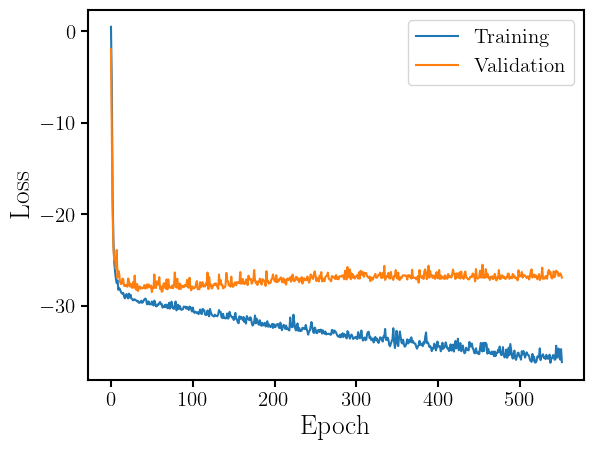

In [6]:
model = NINf.NoInterNet_fraction_compress_inference(lenk, 64, n_min=32).to(device)
NIN.resume(model, "../trained-model/fiducial/RSD/outbox-1321.00-iz1-01norm/NoInterNet-LogLoss-2000-P0-P0-moments/best_model-64.pth", device)

plot_history("../trained-model/fiducial/RSD/outbox-1321.00-iz1-01norm/NoInterNet-LogLoss-2000-P0-P0-moments/")

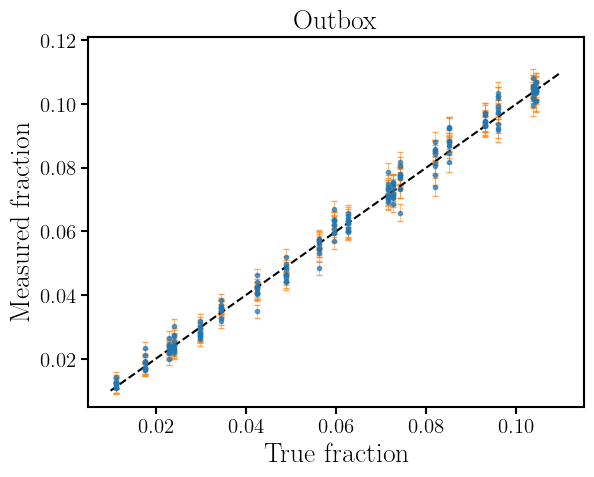

MSE error: 8.861702e-06


In [7]:
plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, limits=[0.005, 0.121], title='Outbox') #, save='../figures/fraction-scatter-outbox-fixed-P0-P0.pdf'

In [8]:
chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)

0
Reduced chi2: 1.3091136169433595


/tmp/ipykernel_27750/1696590091.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


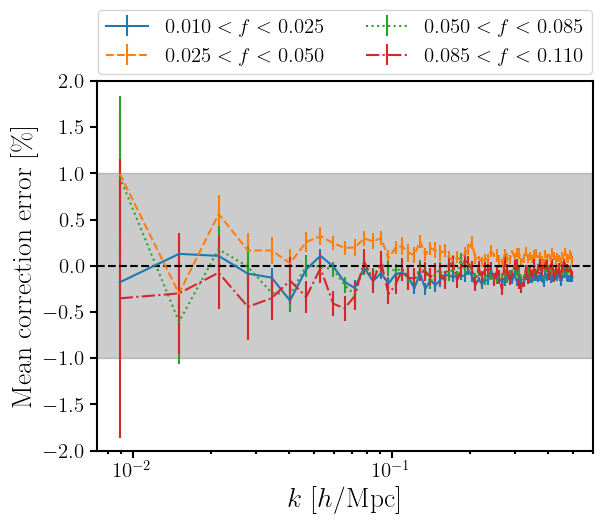

In [9]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-2.,2.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
#plt.savefig('../figures/MCE-outbox-fixed-P0-P0.pdf', bbox_inches='tight')
plt.show()


### P0 B0 -> P0

In [10]:
PBs, labels, lenP, lenB = NINf.load_PBf("outbox-all-fs-RSD-fiducial.csv", "fractions-fiducial.txt", k_max=.5, log=False, norm_fs=True)

max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

PBs, labels, lenP, lenB = NINf.load_PBf("outbox-all-fs-RSD-fiducial.csv", "fractions-fiducial.txt", k_max=.5, log=False, norm_fs=True, norm_c=True)

max_PBs = PBs.max(axis=0)
min_PBs = PBs.min(axis=0)
PBs = NINf.maxmin_corr(PBs, max_PBs, min_PBs)
norm = np.ones(len(PBs))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)

for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

PBs_test = PBs[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])

test = NIN.PkDataset(PBs_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

1 256 128
2 128 64
3 64 32
4 32 16
5 16 32
6 32 64


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

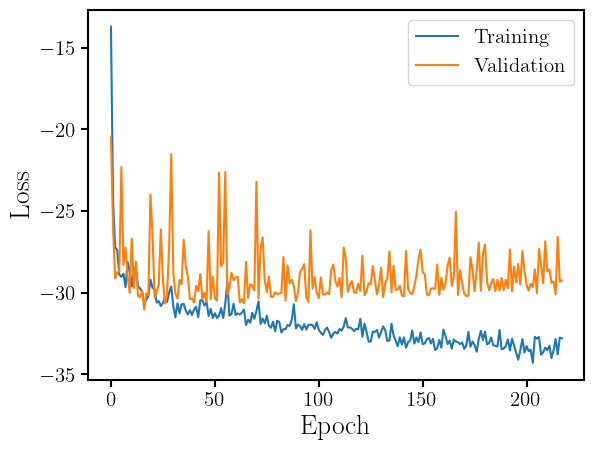

In [11]:
model = NINf.NoInterNet_fraction_compress_inference(lenP+lenB, 256, lenP, 64, 16).to(device)
NIN.resume(model, "../trained-model/fiducial/RSD/outbox-1321.00-iz1-01norm/NoInterNet-LogLoss-2000-P0B0-P0-moments/best_model-256.pth", device)

plot_history("../trained-model/fiducial/RSD/outbox-1321.00-iz1-01norm/NoInterNet-LogLoss-2000-P0B0-P0-moments/", log=False)

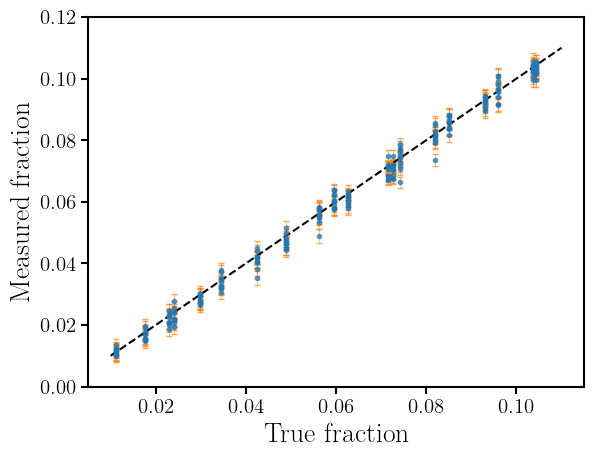

MSE error: 6.322728e-06


In [12]:
plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, save=None)

In [13]:
chi2(test, model, lenk=lenP, device=device, norm_fs=True, thresh=1e-3)

0
Reduced chi2: 1.4811026000976562


## Inbox

### P0 -> P0

In [14]:
Pks, labels, lenk = NINf.load_Pkf("inbox-all-fs-RSD-fiducial.csv", "fractions-fiducial.txt", k_max=.5, log=False, norm_fs=True)
print(lenk)
max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

Pks, labels, lenk = NINf.load_Pkf("inbox-all-fs-RSD-fiducial.csv", "fractions-fiducial.txt", k_max=.5, log=False, norm_fs=True, norm_c=True)

max_Pks = Pks.max(axis=0)
min_Pks = Pks.min(axis=0)
Pks = NINf.maxmin_corr(Pks, max_Pks, min_Pks)
norm = np.ones(len(Pks))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)

for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

Pks_test = Pks[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])

test = NIN.PkDataset(Pks_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

79


1 64 32
2 32 64


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

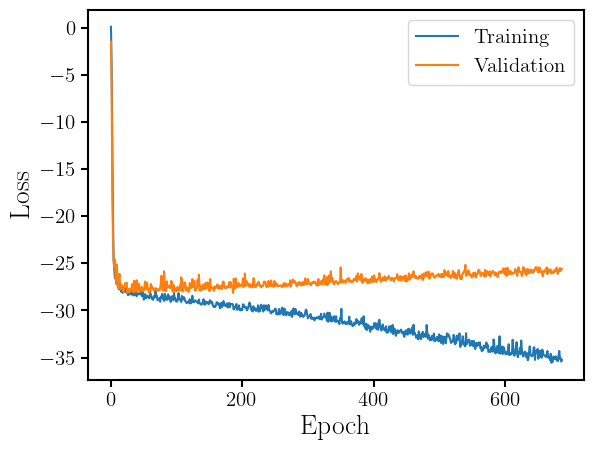

In [15]:
model = NINf.NoInterNet_fraction_compress_inference(lenk, 64, n_min=32).to(device)
NIN.resume(model, "../trained-model/fiducial/RSD/inbox-90.00-01norm/NoInterNet-LogLoss-2000-P0-P0-moments/best_model-64.pth", device)

plot_history("../trained-model/fiducial/RSD/inbox-90.00-01norm/NoInterNet-LogLoss-2000-P0-P0-moments/")

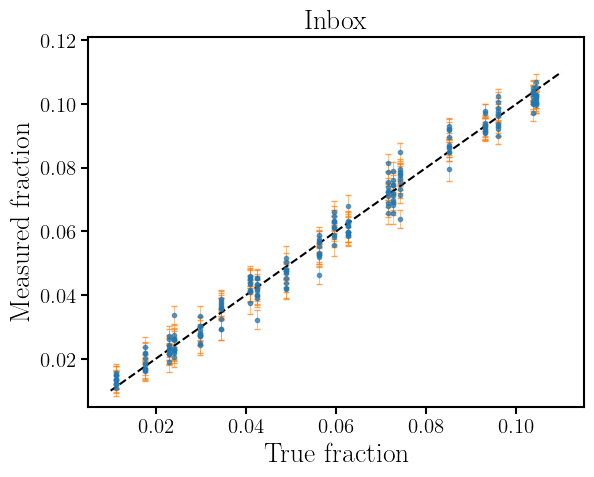

MSE error: 1.3007266e-05


In [16]:
plot_fraction(test, model, lenk=lenk, device=device, norm_fs=True, limits=[0.005, 0.121], title='Inbox') #, save='../figures/fraction-scatter-inbox-fixed-P0-P0.pdf'

In [17]:
chi2(test, model, lenk=lenk, device=device, norm_fs=True, thresh=1e-3)

0
Reduced chi2: 1.4987745666503907


/tmp/ipykernel_27750/1055078608.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0.,0.6)


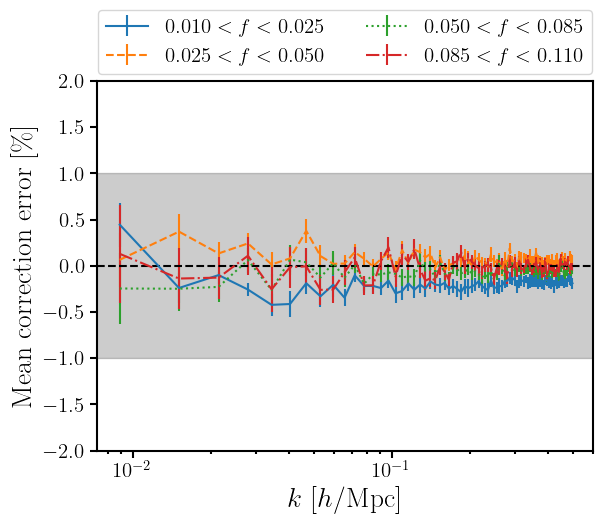

In [18]:
ks = np.loadtxt('ks-gris.dat')

p_mean1, y_mean1, std_mean1, m1, sm1, N1 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.001, 0.025, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean2, y_mean2, std_mean2, m2, sm2, N2 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.025, 0.050, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean3, y_mean3, std_mean3, m3, sm3, N3 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.050, 0.085, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)
p_mean4, y_mean4, std_mean4, m4, sm4, N4 = plot_mean_error_f(test, model, 0.5, ks, device, lenk, 0.085, 0.110, k_min=0, norm_fs=True, max_corr=max_corr, min_corr=min_corr, plot=False)

sel = (ks> 0.) & (ks < 0.5)
k_plot = ks[sel]

plt.errorbar(k_plot, m1[:lenk] * 100., yerr=sm1[:lenk]*100., label='$0.010 < f < 0.025$', linestyle='solid')
plt.errorbar(k_plot, m2[:lenk] * 100., yerr=sm2[:lenk]*100., label='$0.025 < f < 0.050$', linestyle='dashed')
plt.errorbar(k_plot, m3[:lenk] * 100., yerr=sm3[:lenk]*100., label='$0.050 < f < 0.085$', linestyle='dotted')
plt.errorbar(k_plot, m4[:lenk] * 100., yerr=sm4[:lenk]*100., label='$0.085 < f < 0.110$', linestyle='dashdot')

plt.axhline(0, color='k', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$k$ [$h$/Mpc]')
plt.ylim(-2.,2.)
plt.xlim(0.,0.6)
plt.ylabel('''Mean correction error [$\\%$]''')

plt.fill_between([0., .6], -1, 1, alpha=.2, color='k')

plt.legend(ncols=2, loc='lower center', bbox_to_anchor=(0.5,0.99))
#plt.tight_layout()
#plt.savefig('../figures/MCE-inbox-fixed-P0-P0.pdf', bbox_inches='tight')
plt.show()


### P0 B0 -> P0

In [19]:
PBs, labels, lenP, lenB = NINf.load_PBf("inbox-all-fs-RSD-fiducial.csv", "fractions-fiducial.txt", k_max=.5, log=False, norm_fs=True)

max_corr = labels[:,:-1].max(axis=0)
min_corr = labels[:,:-1].min(axis=0)

PBs, labels, lenP, lenB = NINf.load_PBf("inbox-all-fs-RSD-fiducial.csv", "fractions-fiducial.txt", k_max=.5, log=False, norm_fs=True, norm_c=True)

max_PBs = PBs.max(axis=0)
min_PBs = PBs.min(axis=0)
PBs = NINf.maxmin_corr(PBs, max_PBs, min_PBs)
norm = np.ones(len(PBs))

fs = labels[:,-1]

_, ind = np.unique(fs, return_index=True)
f_u = np.array([fs[indx] for indx in sorted(ind)]) #non ordered unique interloper fraction array

n_train = int(len(f_u)*0.75)
n_val = int(len(f_u)*0.9)

fs_test = (f_u[n_val:])

sel_test = np.array([], dtype=int)

for f in fs_test: sel_test= np.append(sel_test, np.where(fs == f)[0])

PBs_test = PBs[sel_test]
labels_test = labels[sel_test]

norm_test = np.array(norm[sel_test, np.newaxis])

test = NIN.PkDataset(PBs_test, labels_test, norm_test)

test_batch = 10
test_dataloader = DataLoader(test, batch_size=test_batch, shuffle=True)

1 256 128
2 128 64
3 64 32
4 32 16
5 16 32
6 32 64


/home/cagliari/Documents/Work/LAPTh/interloper-Pk/NoInterNet/notebooks/../src/training/NoInterNet_model.py:200: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_stat

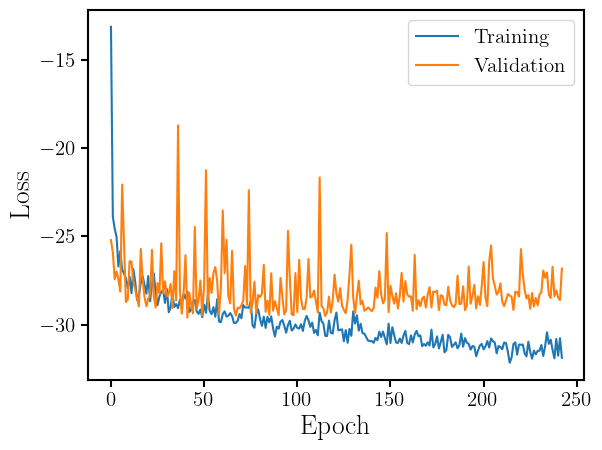

In [20]:
model = NINf.NoInterNet_fraction_compress_inference(lenP+lenB, 256, lenP, 64, 16).to(device)
NIN.resume(model, "../trained-model/fiducial/RSD/inbox-90.00-01norm/NoInterNet-LogLoss-2000-P0B0-P0-moments/best_model-256.pth", device)

plot_history("../trained-model/fiducial/RSD/inbox-90.00-01norm/NoInterNet-LogLoss-2000-P0B0-P0-moments/", log=False)

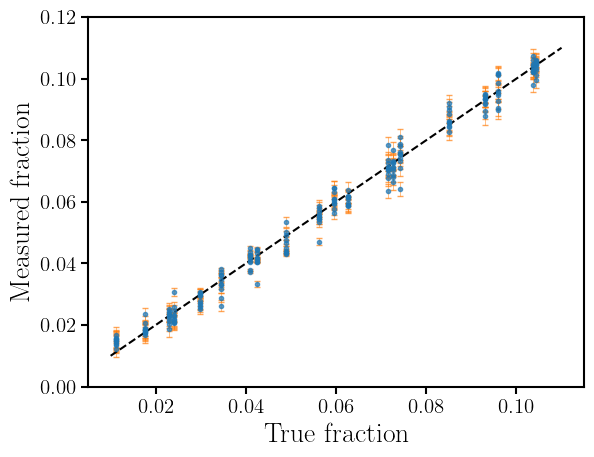

MSE error: 9.914291e-06


In [21]:
plot_fraction(test, model, lenk=lenP, device=device, norm_fs=True, save=None)

In [22]:
chi2(test, model, lenk=lenP, device=device, norm_fs=True, thresh=1e-3)

29
Reduced chi2: 2.4204383850097657
